# Stabla odlučivanja 🌳

In [1]:
import pydot
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from collections import Counter
from termcolor import colored, cprint

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

## Klasifikacija uz korišćenje drveta odlučivanja

<b>Stabla (drveta) odlučivanja</b> predstavljaju grupu algoritama koji spadaju u kategoriju nadgledanog učenja i koji imaju veliku primenu u problemima koji se odnose na klasifikaciju i regresiju kolekcija podataka. Skup podataka <i> Spam emails </i> inicijalno je kreiran sa idejom da se iskoristi za pravljenje filtera koji će moći da razdvoje neželjenu poštu od one koja to nije. Iz tog razloga, pokušavamo da kreiramo dobar klasifikator korišćenjem upravo algoritama iz ove grupe. 

Iako postoje raznovrsni algoritmi koji spadaju u ovu grupu, biblioteka <i> scikit-learn </i> nema podršku za veći broj njih. Konkretno, <b>DecisionTreeClassifier</b> koji se koristi za kreiranje modela, radi u pozadini uz korišćenje optimizovane verzije <b>CART (Classifcation and Regression Tree)</b> algoritma.

### Učitavanje i preprocesiranje podataka

In [2]:
def parse_attributes(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        print(e)
    
    words = [line[0 : line.index(':')][10:] for line in lines[33:81]]
    chars = [line[0 : line.index(':')][10:] for line in lines[81:87]]
    
    feature_names = words + chars
    
    for line in lines[87 : ]:
        feature_names.append(line[0 : line.index(':')])
        
    feature_names += ['class']
    
    return feature_names

In [3]:
feature_names = parse_attributes('../../dataset/spambase.names')
data = pd.read_csv('../../dataset/spambase.data', names= feature_names)

In [4]:
data.head()

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
print(f'Skup ima {data.shape[0]} instancu i {data.shape[1]} atributa.')

Skup ima 4601 instancu i 58 atributa.


Osnovne statistike podataka sa kojima baratamo:

In [6]:
data.describe()

,make,address,all,3d,our,over,remove,internet,order,mail,...,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [7]:
cprint('Nazivi atributa:', attrs= ['bold'])
_ = list(map(lambda name: cprint(name, 'red', attrs= ['bold']), data.columns))

Nazivi atributa:
make
address
all
3d
our
over
remove
internet
order
mail
receive
will
people
report
addresses
free
business
email
you
credit
your
font
000
money
hp
hpl
george
650
lab
labs
telnet
857
data
415
85
technology
1999
parts
pm
direct
cs
meeting
original
project
re
edu
table
conference
;
(
[
!
$
#
capital_run_length_average
capital_run_length_longest
capital_run_length_total
class


Prilikom analize podataka, mogli smo da primetimo da skup nema nedostajuće vrednosti ni za jedan od atributa.

In [8]:
data.isna().sum()

make                          0
address                       0
all                           0
3d                            0
our                           0
over                          0
remove                        0
internet                      0
order                         0
mail                          0
receive                       0
will                          0
people                        0
report                        0
addresses                     0
free                          0
business                      0
email                         0
you                           0
credit                        0
your                          0
font                          0
000                           0
money                         0
hp                            0
hpl                           0
george                        0
650                           0
lab                           0
labs                          0
telnet                        0
857     

#### Izbacivanje dupliranih instanci

In [9]:
print(f'U skupu postoji {sum(data.duplicated())} dupliranih instanci.')

U skupu postoji 391 dupliranih instanci.


> Pošto imamo redove koji su duplirani, njih ćemo izbaciti i nećemo ih koristiti za dalje kalkulacije.

In [10]:
data = data.drop_duplicates()
data.shape

(4210, 58)

#### Podela podataka na prediktore i ciljnu promenljivu

Podatke delimo na one koje ćemo koristiti za predviđanje, kao i na ciljnu promenljivu. U ovom slučaju, promenljiva koju predviđamo će biti `class`. 

Ona uzima dve moguće vrednosti:
- `0`: pošta nije neželjena
- `1`: pošta jeste neželjena

In [11]:
y = data[['class']]
y.shape

(4210, 1)

In [12]:
X = data.drop('class', axis= 1)
X.shape

(4210, 57)

#### Provera balansiranosti klasa

In [13]:
def class_distribution(y):
    colors = sns.color_palette("dark")[1:3]

    plt.pie(y.value_counts(), labels= ['Non spam', 'Spam'], colors= colors, startangle= 55, explode= (0.1, 0.0), 
        shadow= True, autopct= '%.1f%%')
    plt.title('Grafički prikaz procentualnog udela svake od klasa u skupu')
    plt.show()

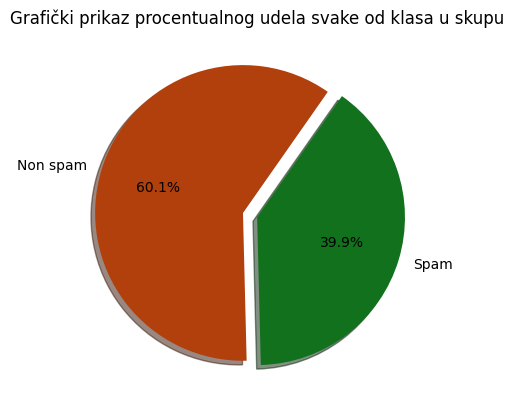

In [14]:
class_distribution(y)

> Vidimo da je među podacima dominantnija klasa koja predstavlja poštu koja nije neželjena. Za prvi pokušaj, vršimo kreiranje modela <i> bez </i> balansiranja klasa, da bismo posle mogli da uporedimo rezultate.

In [15]:
def plot_histograms():
    _ = pd.DataFrame.hist(data, column= data.columns[:20], grid= True, figsize= (20, 20), color= 'darkcyan', bins= 15)
    _ = pd.DataFrame.hist(data, column= data.columns[21:41], grid= True, figsize= (20, 20), color= 'darkcyan', bins= 15)
    _ = pd.DataFrame.hist(data, column= data.columns[42:57], grid= True, figsize= (20, 20), color= 'darkcyan', bins= 15)

#### Raspodele vrednosti za svaki od atributa

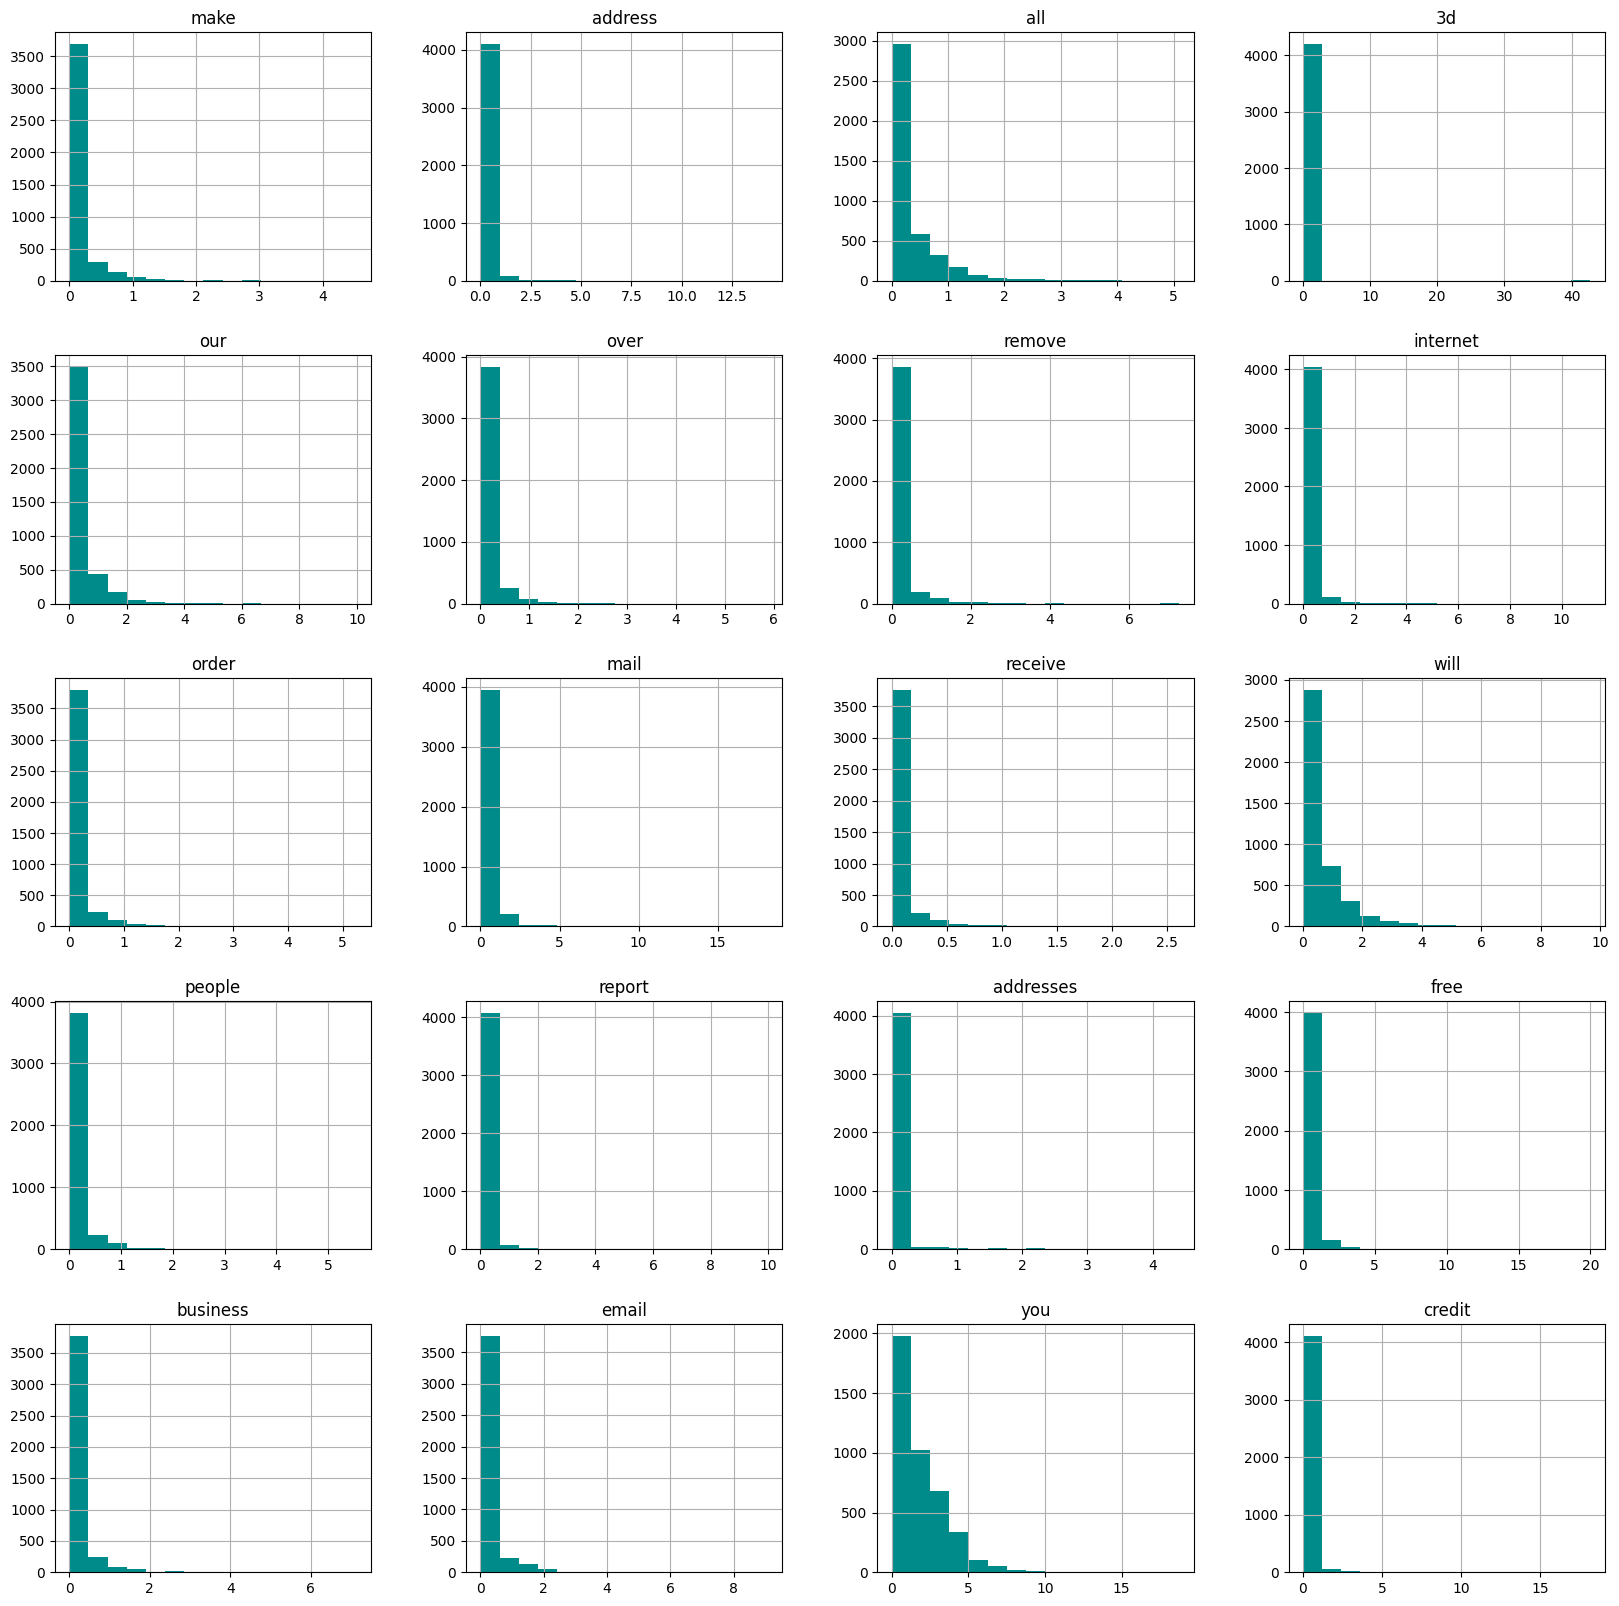

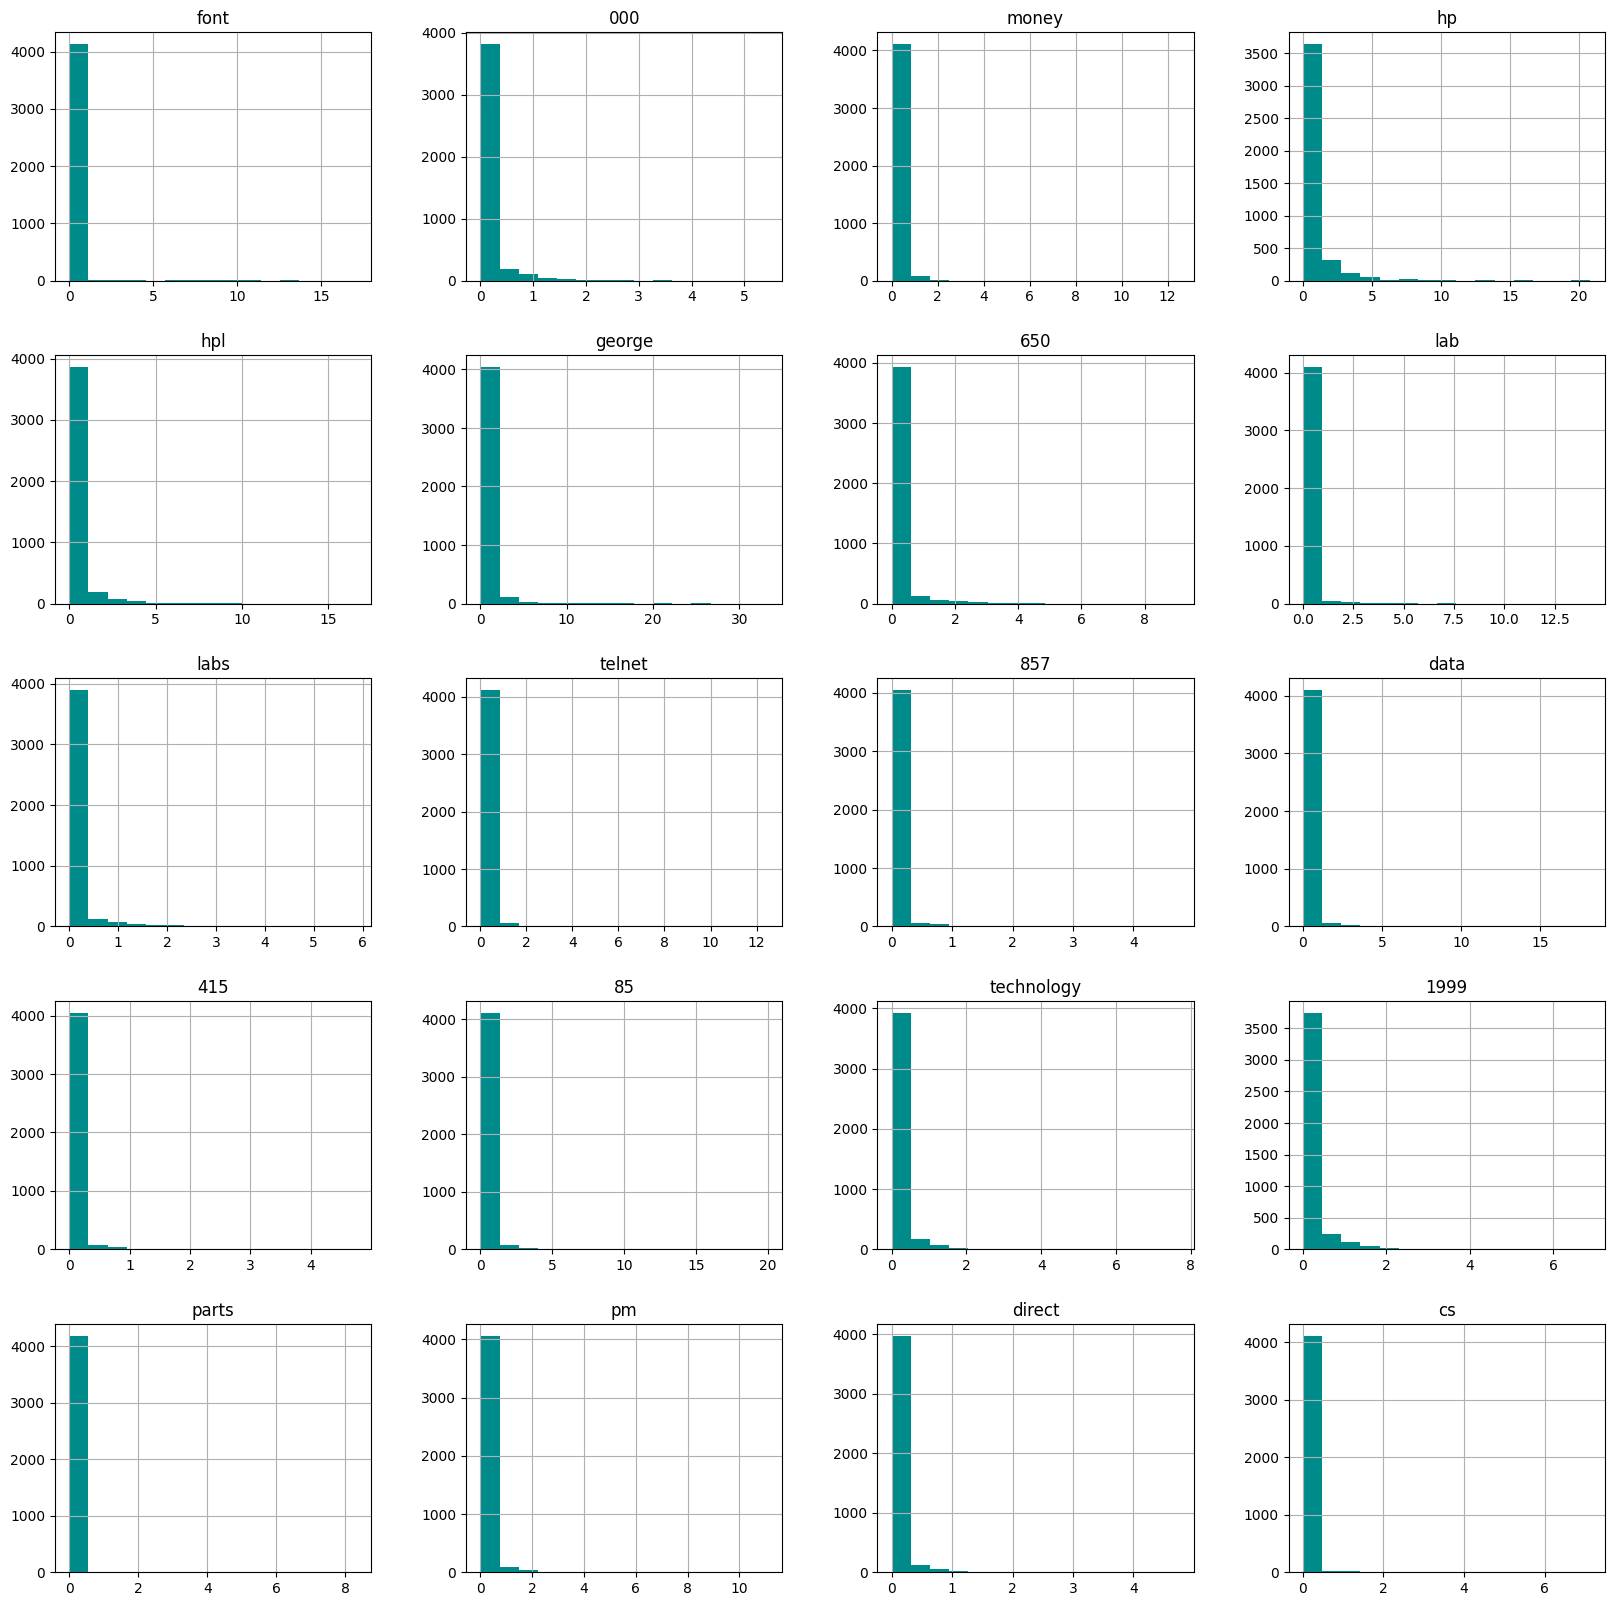

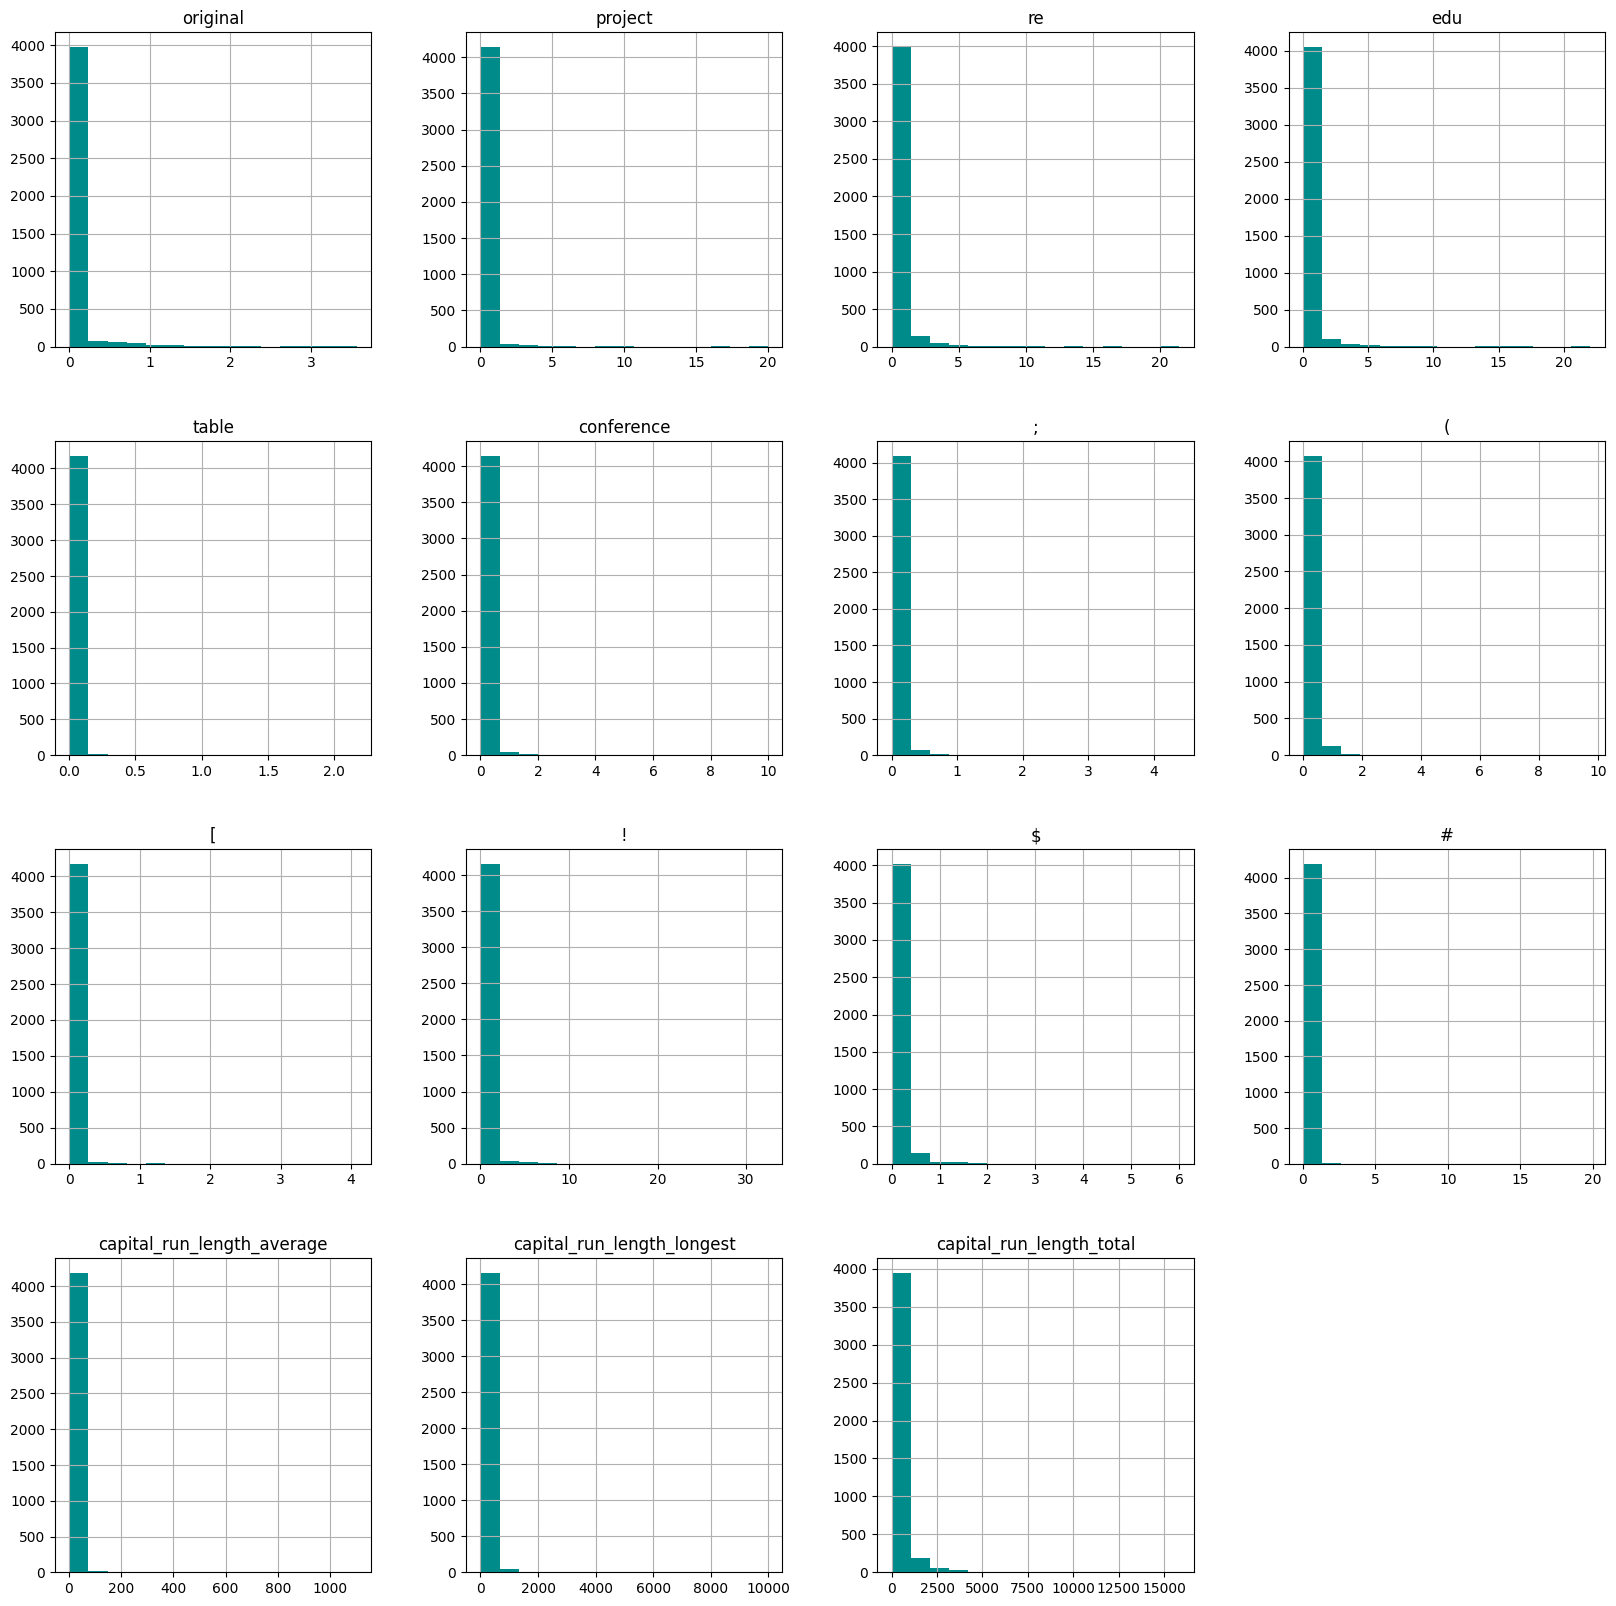

In [16]:
plot_histograms()

#### Podela na trening i test podatke

Razdvajamo podatke koje ćemo koristiti za trening od onih koje ćemo koristiti za testiranje modela. Za veličinu skupa za testiranje u ovom slučaju uzimamo 25% ukupnog broja podataka iz skupa.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42, stratify= y)

In [18]:
X_train

,make,address,all,3d,our,over,remove,internet,order,mail,...,conference,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
442,0.59,0.09,0.09,0.0,0.29,0.09,0.0,0.59,0.59,2.09,...,0.0,0.044,0.078,0.000,0.334,0.133,0.011,15.493,1171,2541
3876,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.83,0.00,0.00,...,0.0,0.000,0.159,0.000,0.000,0.000,0.000,1.848,13,122
3037,0.00,0.00,0.00,0.0,3.84,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,7
375,0.00,0.00,0.00,0.0,0.45,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000,0.000,0.076,0.153,0.000,0.000,3.317,11,136
321,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.67,0.00,0.67,...,0.0,0.170,0.511,0.085,0.511,0.000,0.000,4.617,27,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.73,...,0.0,0.000,0.555,0.666,0.000,0.000,0.111,2.351,12,127
1999,0.00,0.00,0.00,0.0,0.00,0.69,0.0,0.00,0.23,0.00,...,0.0,0.033,0.000,0.033,0.000,0.000,0.000,1.554,13,143
2126,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.79,0.00,0.00,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.309,8,55
1615,0.00,0.00,0.36,0.0,0.73,0.00,0.0,0.00,0.00,0.73,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,2.130,12,228


In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [20]:
X_train

array([[0.12995595, 0.00630252, 0.01764706, ..., 0.01420186, 0.11714057,
        0.16035354],
       [0.        , 0.        , 0.        , ..., 0.00083097, 0.00120144,
        0.00763889],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00037879],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00030279, 0.00070084,
        0.00340909],
       [0.        , 0.        , 0.07058824, ..., 0.0011073 , 0.00110132,
        0.01433081],
       [0.01982379, 0.        , 0.        , ..., 0.00162469, 0.00230276,
        0.03636364]])

In [21]:
X_test

,make,address,all,3d,our,over,remove,internet,order,mail,...,conference,;,(,[,!,$,#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
1754,0.10,0.10,0.71,0.0,0.61,0.30,0.40,0.10,1.42,0.81,...,0.0,0.0,0.000,0.264,0.975,0.396,0.033,3.186,56,1042
530,0.00,0.00,0.20,0.0,0.40,0.20,0.00,0.00,0.00,0.00,...,0.0,0.0,0.000,0.000,0.382,0.223,0.478,7.538,55,490
600,0.49,0.32,0.46,0.0,0.05,0.16,0.05,0.24,0.46,0.79,...,0.0,0.0,0.064,0.000,0.322,0.626,0.165,6.896,193,3269
1768,0.00,0.00,0.37,0.0,0.00,0.00,0.37,0.00,0.00,0.00,...,0.0,0.0,0.302,0.000,0.241,0.060,0.000,2.166,18,143
2502,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,1.750,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.121,0.000,0.000,0.000,0.000,1.387,5,43
1853,0.00,0.00,1.21,0.0,0.00,2.43,0.00,0.00,0.00,0.00,...,0.0,0.0,0.211,0.000,0.211,0.000,0.000,1.000,1,11
139,0.00,0.00,0.00,0.0,1.65,0.00,0.00,0.00,0.82,0.00,...,0.0,0.0,0.415,0.000,0.000,0.000,0.000,1.769,11,69
2755,0.00,0.00,0.00,0.0,2.08,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.131,0.000,0.329,0.000,0.065,2.962,11,157


In [22]:
X_test = scaler.transform(X_test)
X_test

array([[0.02202643, 0.0070028 , 0.13921569, ..., 0.00214209, 0.00550661,
        0.0657197 ],
       [0.        , 0.        , 0.03921569, ..., 0.00640666, 0.00540649,
        0.03087121],
       [0.10792952, 0.02240896, 0.09019608, ..., 0.00577756, 0.01922307,
        0.20631313],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00075355, 0.0010012 ,
        0.00429293],
       [0.        , 0.        , 0.        , ..., 0.00192259, 0.0010012 ,
        0.00984848],
       [0.        , 0.        , 0.09803922, ..., 0.00324253, 0.00370445,
        0.01489899]])

## Kreiranje modela

### Prvi pokušaj - podrazumevani parametri

Pri kreiranju modela u prvom pokušaju koristimo podrazumevane parametre koje nam DecisionTreeClassifier pruža.

Parametri koji su trenutno postavljeni:
- `criterion: gini` - kriterijum po kom se vrši podela na dva potomka u drvetu
- `min_samples_leaf: 1` - minimalan broj elemenata koji se moraju naći u listu
- `min_samples_split: 2` - minimalan broj elemenata koji se moraju naći u čvoru da bi se dalje vršile podele

Takođe, u ovom pokušaju nećemo vršiti balansiranje klasa.

In [23]:
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

def report(model, x, y, text = "trening", ):
    y_pred = model.predict(x)
    
    print(colored('\t' + f'Klasifikacioni izveštaj za model {type(model).__name__} nad {text} podacima', 'blue', attrs= ['bold']))
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])
    cprint(classification_report(y, y_pred), attrs= ['dark']) 
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])
    

def plot_confusion_matrix(model, x, y, text = 'training'):
    y_pred = model.predict(x)
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', ax=ax, cmap= plt.cm.Blues)
    
    ax.set_xlabel('Predviđene vrednosti')
    ax.set_ylabel('Stvarne vrednosti')
    
    ax.set_title('Matrica konfuzije') 
    ax.xaxis.set_ticklabels(['Non spam', 'Spam'])
    ax.yaxis.set_ticklabels(['Non spam', 'Spam'])

def decision_tree_parameters(model, feature_names):
    print(colored('\t' + f'Parametri modela {type(model).__name__}', 'blue', attrs= ['bold']))
    cprint("-----------------------------------------------------------", attrs= ['bold'])
    for k, v in model.get_params().items():
        print(colored('\t' + k, 'red', attrs= ['bold']), v)
    
    cprint("-----------------------------------------------------------\n\n", attrs= ['bold'])
    print(colored('\t' + 'Dodatne informacije o drvetu', 'blue', attrs= ['bold', 'concealed']))
    cprint("-----------------------------------------------------------", attrs= ['bold'])
    print(colored('\t' + 'Dubina: ', 'red', attrs= ['bold', 'concealed']), model.get_depth())
    print(colored('\t' + 'Broj listova: ', 'red', attrs= ['bold', 'concealed']), model.get_n_leaves())
    cprint("-----------------------------------------------------------", attrs= ['bold'])

def create_decision_tree_image(model, feature_names, ind):
    file_name = f'../../images/dot_files/tree_{ind}.dot'
    image_path = f'../../images/tree_{ind}.png'
    
    tree.export_graphviz(model,
                         out_file= file_name,
                         feature_names = feature_names, 
                         class_names= ['Non spam', 'Spam'],
                         filled = True)

    (graph, ) = pydot.graph_from_dot_file(file_name)
    graph.write_png(image_path)

In [24]:
fst_decision_tree_classifier = DecisionTreeClassifier()
fst_decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

#### Parametri drveta

In [25]:
feature_names.remove('class')
decision_tree_parameters(fst_decision_tree_classifier, feature_names)

	Parametri modela DecisionTreeClassifier
-----------------------------------------------------------
	ccp_alpha 0.0
	class_weight None
	criterion gini
	max_depth None
	max_features None
	max_leaf_nodes None
	min_impurity_decrease 0.0
	min_samples_leaf 1
	min_samples_split 2
	min_weight_fraction_leaf 0.0
	random_state None
	splitter best
-----------------------------------------------------------


	Dodatne informacije o drvetu
-----------------------------------------------------------
	Dubina:  29
	Broj listova:  213
-----------------------------------------------------------


In [26]:
create_decision_tree_image(fst_decision_tree_classifier, feature_names, 0)

![first_decision_tree](../../images/tree_0.png)

In [27]:
def feature_importance(model, feature_names):
    plt.figure(figsize= (14, 10))
    pd.Series(model.feature_importances_, index=feature_names).plot.barh()
    plt.title("Značajnost atributa")
    plt.show()
    
    cprint('Procentualna značajnost atributa: ', attrs= ['bold'])
    for name, importance in zip(feature_names, model.feature_importances_):
        cprint(name + ': ' + str(importance), 'red', attrs= ['bold'])

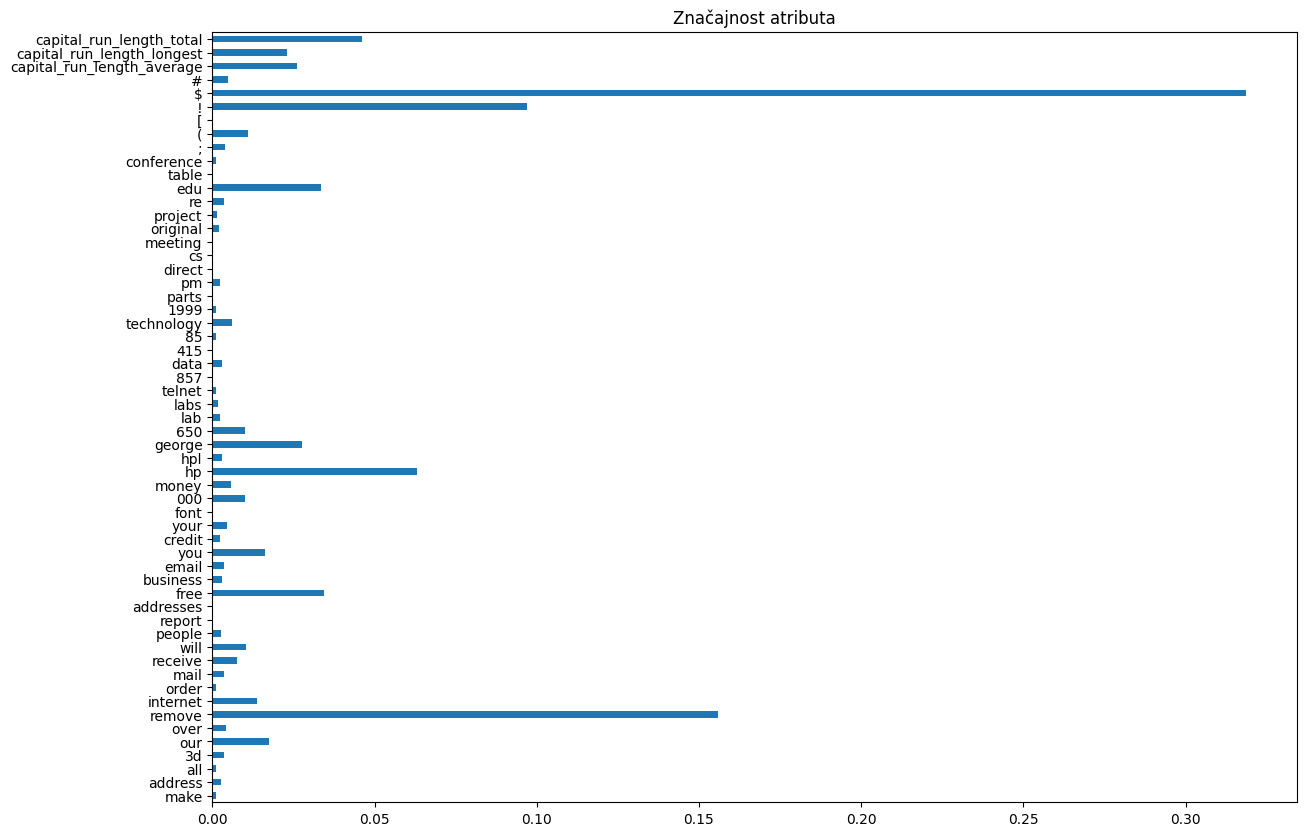

Procentualna značajnost atributa: 
make: 0.0011766888234618965
address: 0.002702707141389044
all: 0.00119139743375517
3d: 0.0034481596993407556
our: 0.017423398826669073
over: 0.004125933606465107
remove: 0.15600031814354073
internet: 0.013658193930586026
order: 0.001241038993494969
mail: 0.00355314523813385
receive: 0.007555721536934093
will: 0.010423158856493248
people: 0.002589146495932425
report: 0.0
addresses: 0.0
free: 0.03447713332293195
business: 0.0030546870059152335
email: 0.0037435679783243128
you: 0.016321565703662354
credit: 0.002348344081561226
your: 0.004557620549387937
font: 0.0
000: 0.010026671040992266
money: 0.005748965394628127
hp: 0.06320194684533437
hpl: 0.0028871997243849193
george: 0.027608406278307487
650: 0.009925726441478506
lab: 0.002302434029905692
labs: 0.0017546506867505334
telnet: 0.0012719244274056205
857: 0.0
data: 0.002987727594573758
415: 0.0
85: 0.001229219574509303
technology: 0.0059115072721874305
1999: 0.0010469047930944805
parts: 0.0
pm: 0.00234

In [28]:
feature_importance(fst_decision_tree_classifier, feature_names)

#### Trening podaci

In [29]:
report(fst_decision_tree_classifier, X_train, y_train)

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1259

    accuracy                           1.00      3157
   macro avg       1.00      1.00      1.00      3157
weighted avg       1.00      1.00      1.00      3157

----------------------------------------------------------------------------------------------


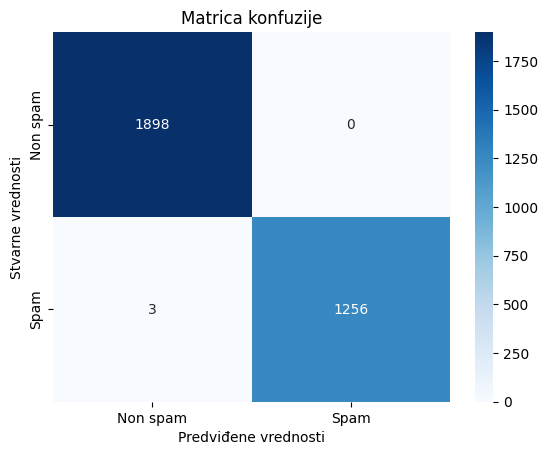

In [30]:
plot_confusion_matrix(fst_decision_tree_classifier, X_train, y_train)

> S obzirom da na trening podacima model daje tačnost <b>1.0</b> možemo zaključiti da se <b>preprilagodio</b> podacima, kao i da će podaci na test skupu biti lošiji. Kada se ovo dogodi, model lošije generalizuje podatke koje do tada nije video. 

#### Test podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       633
           1       0.86      0.87      0.87       420

    accuracy                           0.89      1053
   macro avg       0.89      0.89      0.89      1053
weighted avg       0.89      0.89      0.89      1053

----------------------------------------------------------------------------------------------


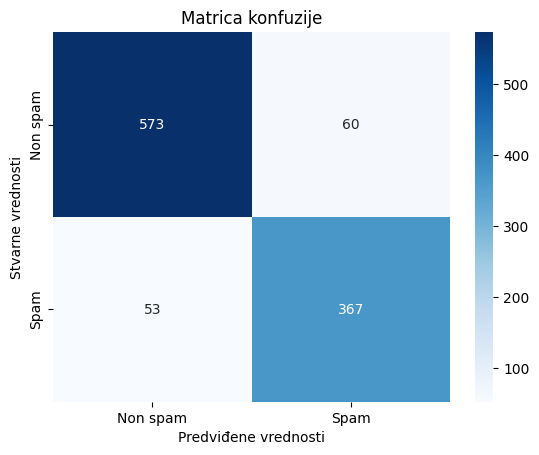

In [31]:
report(fst_decision_tree_classifier, X_test, y_test, 'test')
plot_confusion_matrix(fst_decision_tree_classifier, X_test, y_test)

Na test podacima primećujemo da ima malo promašaja pri klasifikaciji, ali i dalje dobijamo solidne rezultate. <b>Tačnost (engl. accuracy)</b> nam u ovom slučaju iznosi <b>0.89</b>. 

## Izbor najboljih parametara

Kada smo prethodno kreirali model, nismo ručno podešavali nijedan od mogućih parametara, već smo radili sa onim što je podrazumevano. <b>GridSearchCV</b> predstavlja proces kojim se vrši iscrpna pretraga svih kombinacija parametara, a u cilju dobijanja onih parametara pomoću kojih ćemo imati model koji daje najbolje performanse. U toku pretrage vrši se procena modela sa kombinacijom parametara koja se u tekućoj iteraciji ispituje i računaju se njegovi rezultati na skupu za validaciju. S tim u vidu, ovo i predstavlja jednu od tehnika za <b>unakrsnu validaciju</b>.

In [32]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 32),
    'max_features': range(2, 26)
}

fst_estimator = GridSearchCV(DecisionTreeClassifier(), param_grid= params, cv= 3)
snd_estimator = GridSearchCV(DecisionTreeClassifier(class_weight= 'balanced'), param_grid= params, cv= 3)

In [33]:
fst_estimator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 32),
                         'max_features': range(2, 26)})

In [34]:
snd_estimator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 32),
                         'max_features': range(2, 26)})

### Rezultati prvog modela - bez automatskog balansiranja klasa

In [35]:
decision_tree_parameters(fst_estimator.best_estimator_, feature_names)

	Parametri modela DecisionTreeClassifier
-----------------------------------------------------------
	ccp_alpha 0.0
	class_weight None
	criterion entropy
	max_depth 30
	max_features 25
	max_leaf_nodes None
	min_impurity_decrease 0.0
	min_samples_leaf 1
	min_samples_split 2
	min_weight_fraction_leaf 0.0
	random_state None
	splitter best
-----------------------------------------------------------


	Dodatne informacije o drvetu
-----------------------------------------------------------
	Dubina:  28
	Broj listova:  216
-----------------------------------------------------------


In [36]:
create_decision_tree_image(fst_estimator.best_estimator_, feature_names, 1)

![fst_estimator](../../images/tree_1.png)

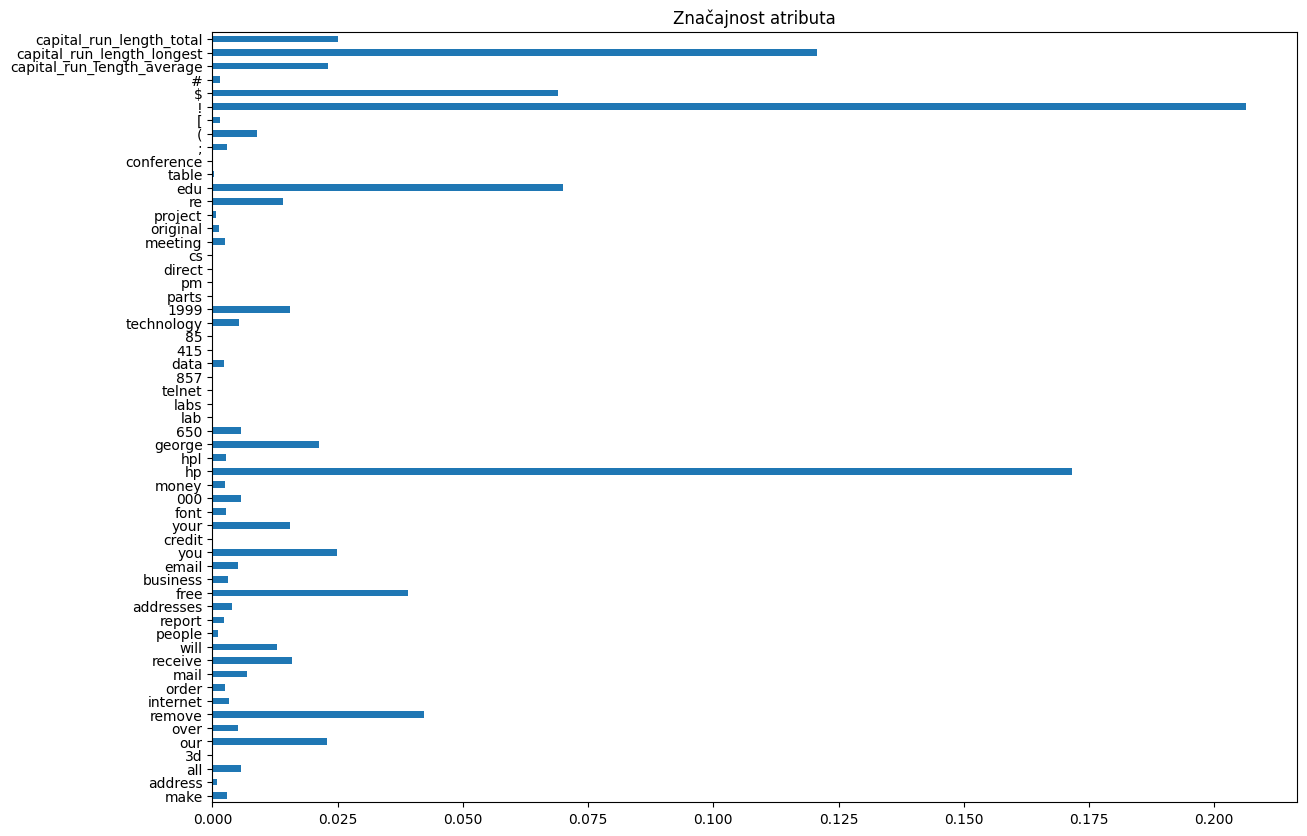

Procentualna značajnost atributa: 
make: 0.0028787393504749953
address: 0.0009011574955407641
all: 0.005639853745803198
3d: 0.0
our: 0.022853241249550613
over: 0.005143373332079759
remove: 0.04218132923374545
internet: 0.0033611041862364136
order: 0.0024425691101054806
mail: 0.006826357150470753
receive: 0.015950879878015144
will: 0.013000690511974363
people: 0.0010802611842703773
report: 0.0022339934655266074
addresses: 0.003981582438787882
free: 0.039155298530956256
business: 0.0032124353113791864
email: 0.0051576532114011595
you: 0.024880530416133438
credit: 0.0
your: 0.01542741125945951
font: 0.002684201854885633
000: 0.00565236578658273
money: 0.00251187926067041
hp: 0.1716891724317118
hpl: 0.002757106523136838
george: 0.021325913279295
650: 0.00563079026488443
lab: 0.0
labs: 0.0
telnet: 0.0
857: 0.0
data: 0.00240522081313285
415: 0.0
85: 0.0
technology: 0.005417850729901736
1999: 0.015595724463077108
parts: 0.0
pm: 0.0
direct: 0.0
cs: 0.0
meeting: 0.002470393221909391
original: 0

In [37]:
feature_importance(fst_estimator.best_estimator_, feature_names)

#### Trening podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1259

    accuracy                           1.00      3157
   macro avg       1.00      1.00      1.00      3157
weighted avg       1.00      1.00      1.00      3157

----------------------------------------------------------------------------------------------


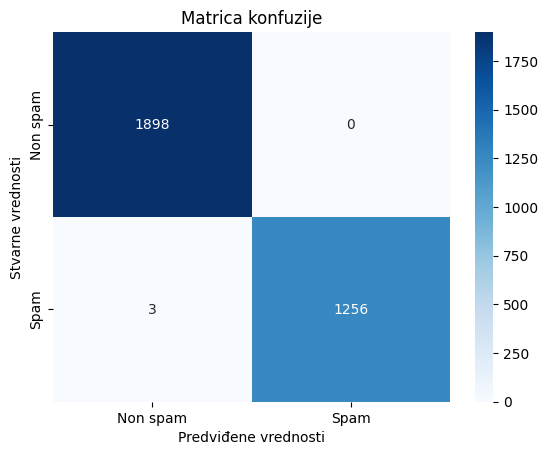

In [38]:
report(fst_estimator.best_estimator_, X_train, y_train)
plot_confusion_matrix(fst_estimator.best_estimator_, X_train, y_train)

#### Test podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       633
           1       0.87      0.88      0.88       420

    accuracy                           0.90      1053
   macro avg       0.90      0.90      0.90      1053
weighted avg       0.90      0.90      0.90      1053

----------------------------------------------------------------------------------------------


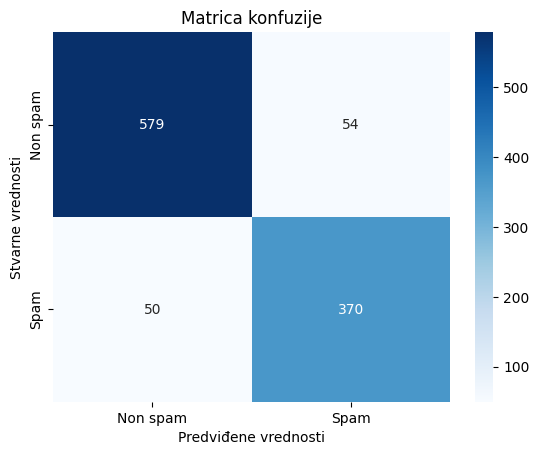

In [39]:
report(fst_estimator.best_estimator_, X_test, y_test)
plot_confusion_matrix(fst_estimator.best_estimator_, X_test, y_test, 'test')

> Uz izbor najboljih parametara, dobijamo malo bolje rezultate nego pri prvom pokušaju. Sada tačnost iznosi <b>0.90</b>.

### Rezultati drugog modela - sa automatskim balansiranjem klasa

In [40]:
decision_tree_parameters(snd_estimator.best_estimator_, feature_names)

	Parametri modela DecisionTreeClassifier
-----------------------------------------------------------
	ccp_alpha 0.0
	class_weight balanced
	criterion gini
	max_depth 8
	max_features 25
	max_leaf_nodes None
	min_impurity_decrease 0.0
	min_samples_leaf 1
	min_samples_split 2
	min_weight_fraction_leaf 0.0
	random_state None
	splitter best
-----------------------------------------------------------


	Dodatne informacije o drvetu
-----------------------------------------------------------
	Dubina:  8
	Broj listova:  75
-----------------------------------------------------------


In [41]:
create_decision_tree_image(snd_estimator.best_estimator_, feature_names, 2)

![snd_estimator](../../images/tree_2.png)

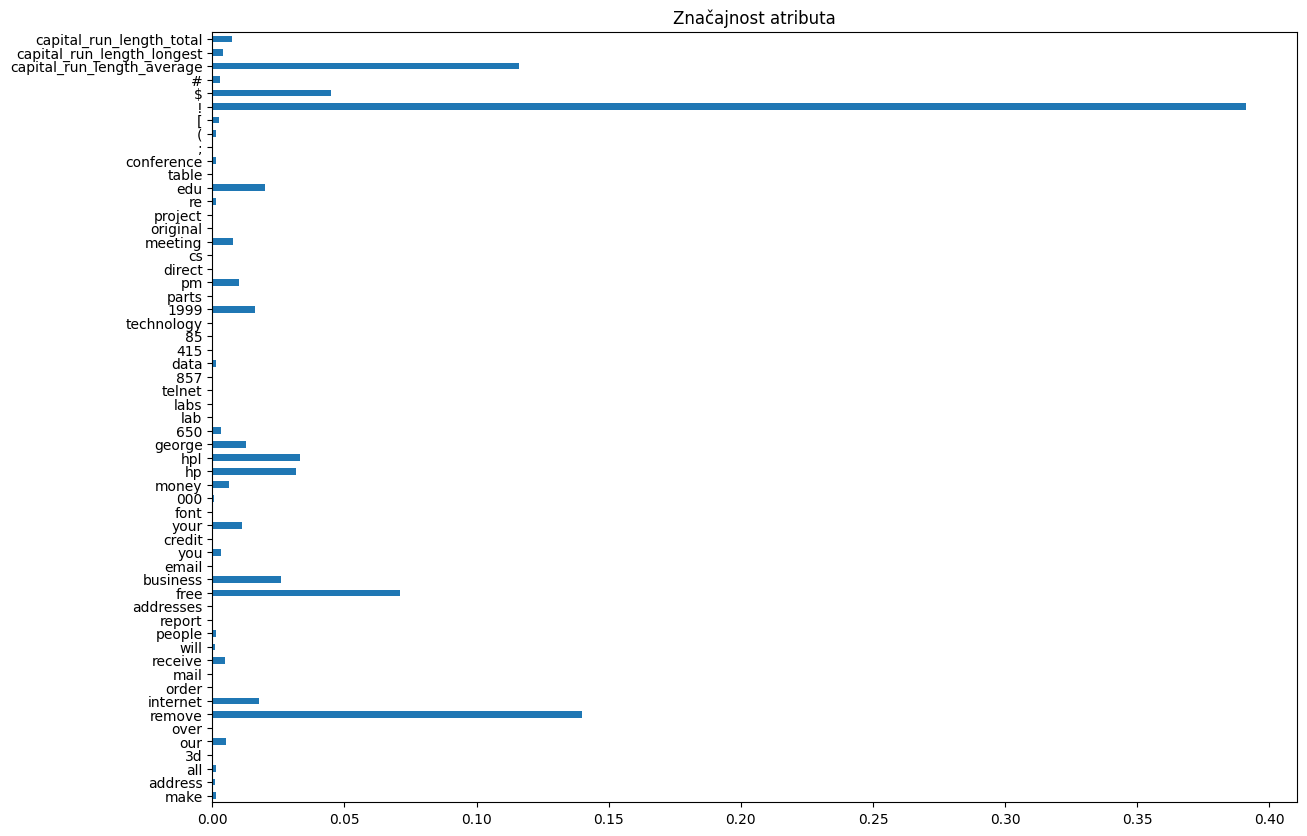

Procentualna značajnost atributa: 
make: 0.001272675768339243
address: 0.0010741731491256104
all: 0.0015581704664496287
3d: 0.0
our: 0.005046732664205807
over: 0.0
remove: 0.13981230458119956
internet: 0.01783461215521375
order: 9.290946671707468e-17
mail: 0.0
receive: 0.004837616189262124
will: 0.0010932677860234401
people: 0.0012333438112728415
report: 0.0
addresses: 0.0
free: 0.07086224829132637
business: 0.02604343984842166
email: 0.0
you: 0.0031507566931328846
credit: 0.0
your: 0.01104333553188653
font: 0.0
000: 0.00047555334542648557
money: 0.006282685683978684
hp: 0.03156266803805488
hpl: 0.03325408136343691
george: 0.012817757369042901
650: 0.0034289234852238277
lab: 0.0
labs: 0.0
telnet: 0.0
857: 0.0
data: 0.0012426999420152875
415: 0.0
85: 0.0
technology: 0.0
1999: 0.01598836718075354
parts: 0.0
pm: 0.010189071020691097
direct: 0.0
cs: 0.0
meeting: 0.007773431304765951
original: 0.0
project: 0.0
re: 0.0012706588197500532
edu: 0.019771449557978795
table: 0.0
conference: 0.0012

In [42]:
feature_importance(snd_estimator.best_estimator_, feature_names)

#### Trening podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1898
           1       0.94      0.92      0.93      1259

    accuracy                           0.95      3157
   macro avg       0.95      0.94      0.95      3157
weighted avg       0.95      0.95      0.95      3157

----------------------------------------------------------------------------------------------


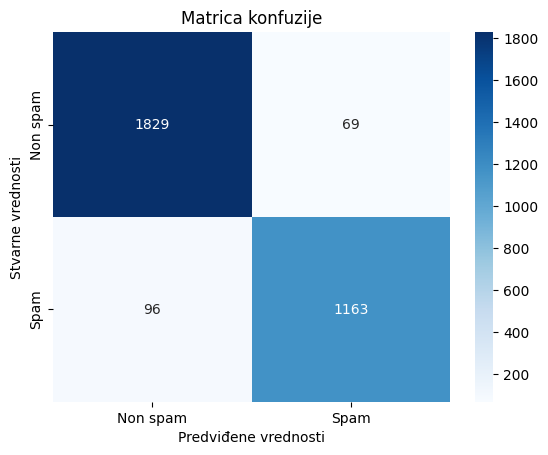

In [43]:
report(snd_estimator.best_estimator_, X_train, y_train)
plot_confusion_matrix(snd_estimator.best_estimator_, X_train, y_train)

> Za razliku od prethodnih modela, sada više tačnost na trening skupu nije 1.0!

#### Test podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       633
           1       0.89      0.89      0.89       420

    accuracy                           0.91      1053
   macro avg       0.91      0.91      0.91      1053
weighted avg       0.91      0.91      0.91      1053

----------------------------------------------------------------------------------------------


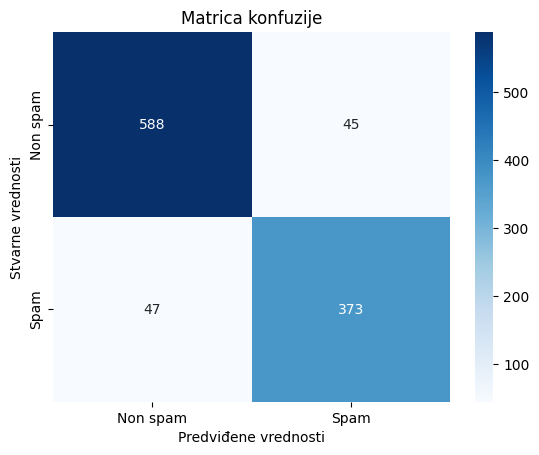

In [44]:
report(snd_estimator.best_estimator_, X_test, y_test, 'test')
plot_confusion_matrix(snd_estimator.best_estimator_, X_test, y_test)

> Na test podacima imamo manje promašaja nego kod modela koji su do sada kreirani, a tačnost je <b>0.91</b>.

### Upoređivanje prethodno kreiranih modela

Prikazujemo grafik na kome bi trebalo da se vidi ponašanje svakog od modela. Konkretno, ovde gledamo <b>AUC (Area under the ROC curve)</b> vrednost, koja bi trebalo da nam pokaže koliko je koji model kvalitetan. Što je ta vrednost bliža <b>jedinici</b>, to model bolje generalizuje.

In [45]:
def plot_ROC_curve(models, model_names, title):

    plt.figure(figsize= (10, 7))
    for model, model_name in zip(models, model_names):
        y_pred = model.predict(X_test)
        fpr,tpr, _ = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        lab = model_name + " (auc: " + str(round(auc, 3)) + ")"
        plt.plot(fpr, tpr, label=lab)

    plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
    plt.title(title)
    plt.legend()
    plt.show()

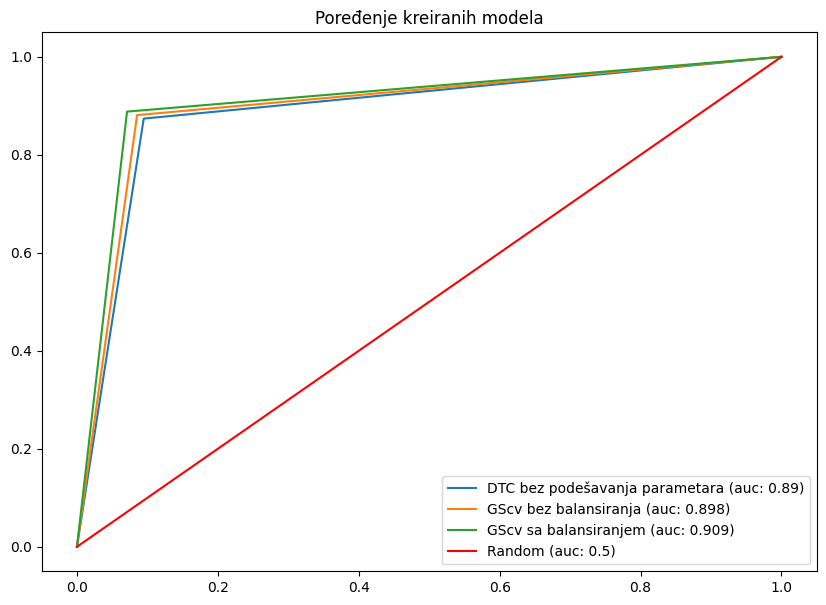

In [46]:
models = [fst_decision_tree_classifier, fst_estimator.best_estimator_, snd_estimator.best_estimator_]
model_names = ['DTC bez podešavanja parametara', 'GScv bez balansiranja', 'GScv sa balansiranjem']

plot_ROC_curve(models, model_names, 'Poređenje kreiranih modela')

> Vidimo da modeli dobijeni uz korišćenje iscrpne pretrage hiper-parametara daju bolje rezultate nego model kreiran sa podrazumevanom konfiguracijom, pri čemu model kod koga je izvršeno <i>automatsko balansiranje klasa</i> daje najbolje rezultate.

## Balansiranje klasa uz tehniku <i> Oversampling </i> ⚖️

Prilikom prvog pokušaja, odlučeno je da se blaga nebalansiranost klasa ne uzima u obzir. Ovog puta, prvo ćemo nekom od metoda izvršiti balansiranje, a zatim nad takvim podacima i kreirati model.

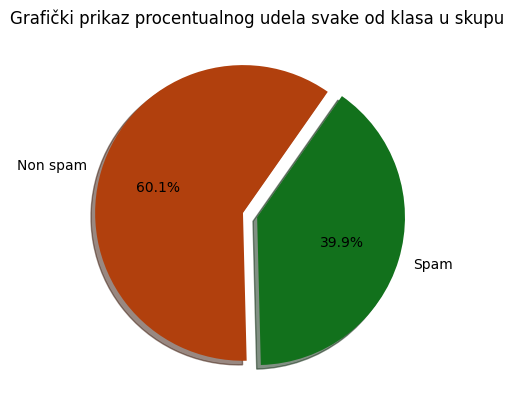

In [47]:
class_distribution(y_train)

> Sa grafika se vidi da je klasa koja čini poštu koja nije neželjena skoro pa duplo brojnija od klase koja označava neželjenu poštu. Iz tog razloga, probaćemo da izjednačimo udeo klase koja je trenutno u deficitu.

In [48]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.3):
    pca = PCA(n_components= 2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['r' if y == -1 else 'red' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resamplinga'.format("Nakon" if i else "Pre"), c = 'blue' if i else 'green')
    plt.show()

Koristimo tehniku over-samplinga, <b>SMOTE (Synthetic Minority Oversampling Technique)</b> koja kreira nove instance primenom interpolacije nad već postojećim podacima.

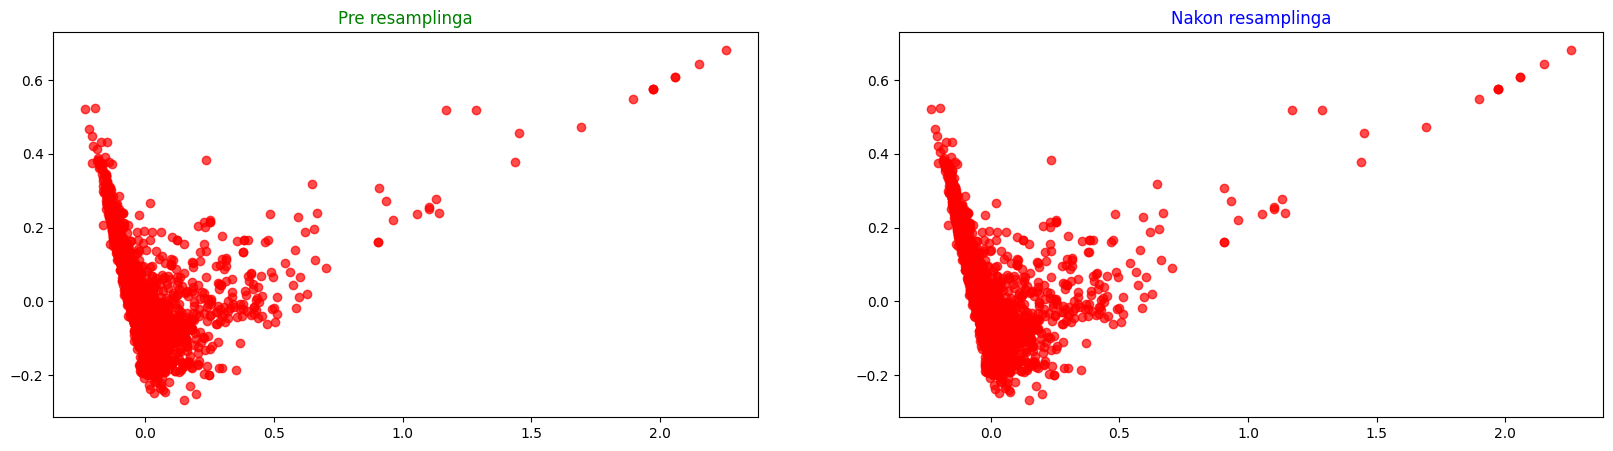

In [49]:
smote = SMOTE(k_neighbors= 10, random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

visualize(X_train, X_resampled, y_train, y_resampled)

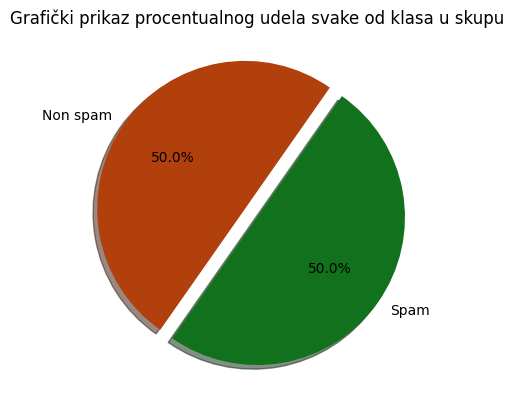

In [50]:
class_distribution(y_resampled)

In [51]:
snd_decision_tree_classifier = DecisionTreeClassifier()
snd_decision_tree_classifier.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

#### Parametri drveta

In [52]:
decision_tree_parameters(snd_decision_tree_classifier, feature_names)

	Parametri modela DecisionTreeClassifier
-----------------------------------------------------------
	ccp_alpha 0.0
	class_weight None
	criterion gini
	max_depth None
	max_features None
	max_leaf_nodes None
	min_impurity_decrease 0.0
	min_samples_leaf 1
	min_samples_split 2
	min_weight_fraction_leaf 0.0
	random_state None
	splitter best
-----------------------------------------------------------


	Dodatne informacije o drvetu
-----------------------------------------------------------
	Dubina:  32
	Broj listova:  241
-----------------------------------------------------------


In [53]:
create_decision_tree_image(snd_decision_tree_classifier, feature_names, 1)

![second_decision_tree](../../images/tree_1.png)

#### Trening podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1898

    accuracy                           1.00      3796
   macro avg       1.00      1.00      1.00      3796
weighted avg       1.00      1.00      1.00      3796

----------------------------------------------------------------------------------------------


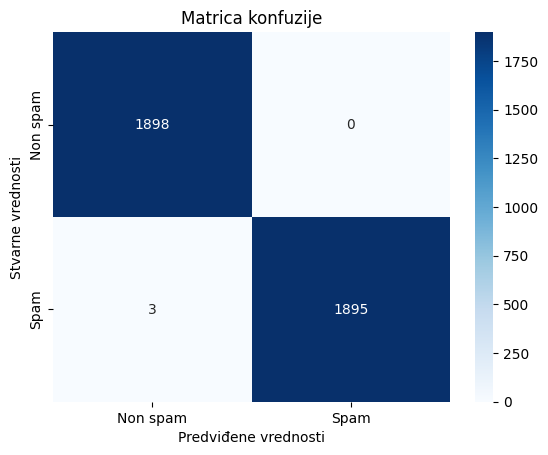

In [54]:
report(snd_decision_tree_classifier, X_resampled, y_resampled)
plot_confusion_matrix(snd_decision_tree_classifier, X_resampled, y_resampled)

#### Test podaci

	Klasifikacioni izveštaj za model DecisionTreeClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       633
           1       0.86      0.90      0.88       420

    accuracy                           0.90      1053
   macro avg       0.90      0.90      0.90      1053
weighted avg       0.90      0.90      0.90      1053

----------------------------------------------------------------------------------------------


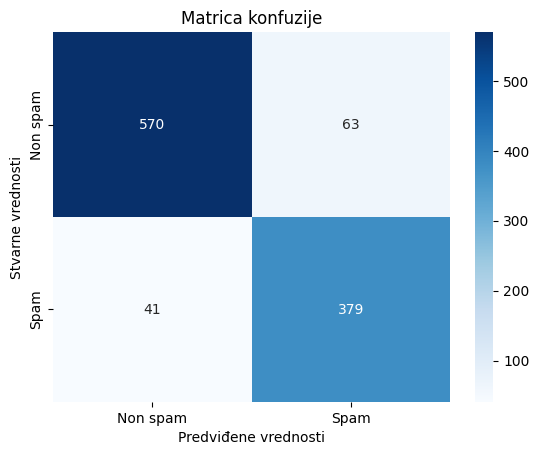

In [55]:
report(snd_decision_tree_classifier, X_test, y_test, 'test')
plot_confusion_matrix(snd_decision_tree_classifier, X_test, y_test)

Iz prethodno formiranih i treniranih modela, kao i prikaza njihovih statistika, možemo primetiti da se dosta slično ponašaju bez obzira da li su klase balansirane ili ne.

## Slučajne šume

<b>Ansambli</b> predstavljaju skupove većeg broja manjih modela koji bi zajedno trebalo da donose odluke sa ciljem da se dobiju najbolje moguće performanse. Ključno je to, da veći broj modela daje bolju preciznost nego što bi to davao samo jedan model. S tim u vidu, ovde će biti korišćen <b>RandomForestClassifier</b>, koji kreira više broj manjih stabala nad određenim podskupom podataka za treniranje i ima za cilj da poveća tačnost, kao i smanji mogućnost preprilagođavanja modela.

In [56]:
random_forest = RandomForestClassifier(n_estimators= 100, random_state=42)
random_forest.fit(X_train, y_train)

/tmp/ipykernel_12442/2880850680.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Trening podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1259

    accuracy                           1.00      3157
   macro avg       1.00      1.00      1.00      3157
weighted avg       1.00      1.00      1.00      3157

----------------------------------------------------------------------------------------------


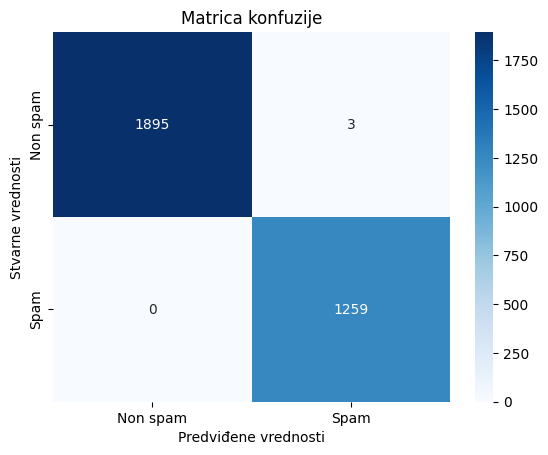

In [57]:
report(random_forest, X_train, y_train)
plot_confusion_matrix(random_forest, X_train, y_train)

#### Test podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       633
           1       0.94      0.92      0.93       420

    accuracy                           0.94      1053
   macro avg       0.94      0.94      0.94      1053
weighted avg       0.94      0.94      0.94      1053

----------------------------------------------------------------------------------------------


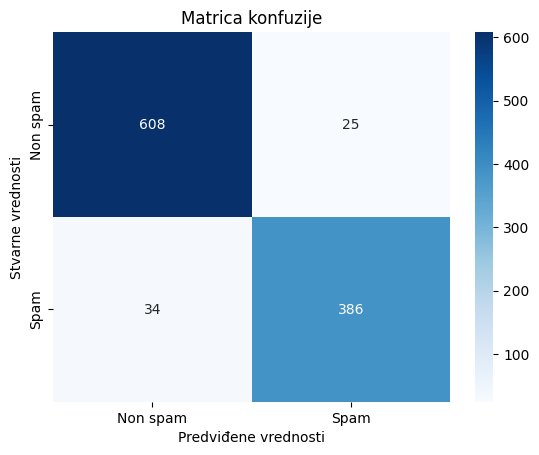

In [58]:
report(random_forest, X_test, y_test, 'test')
plot_confusion_matrix(random_forest, X_test, y_test)

### Upoređivanje modela

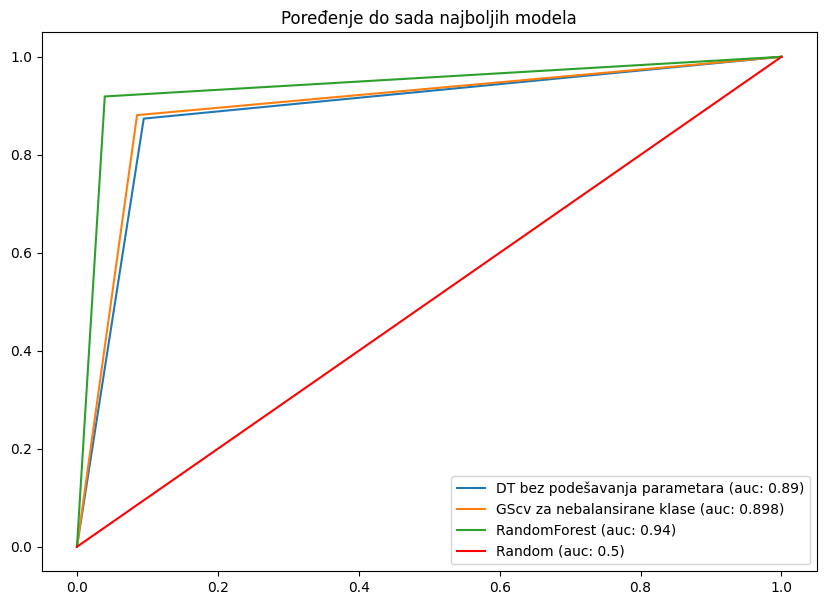

In [59]:
models = [fst_decision_tree_classifier, fst_estimator, random_forest]
model_names = ['DT bez podešavanja parametara', 'GScv za nebalansirane klase', 'RandomForest']

plot_ROC_curve(models, model_names, 'Poređenje do sada najboljih modela')

> Vidimo da model kreiran korišćenjem ansambl metoda daje značajno bolje rezultate u odnosu na sve ostale. AUC vrednost je <b>0.94</b>.

### Šta ako su klase balansirane?

Pravimo novi model metodom ansambala koji će trenirati nad podacima kod kojih su klase <i> balansirane </i>.

In [60]:
snd_random_forest = RandomForestClassifier(n_estimators= 100, random_state= 42)
snd_random_forest.fit(X_resampled, y_resampled)

/tmp/ipykernel_12442/3943675348.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  snd_random_forest.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

#### Trening podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1898
           1       1.00      0.99      0.99      1898

    accuracy                           0.99      3796
   macro avg       0.99      0.99      0.99      3796
weighted avg       0.99      0.99      0.99      3796

----------------------------------------------------------------------------------------------


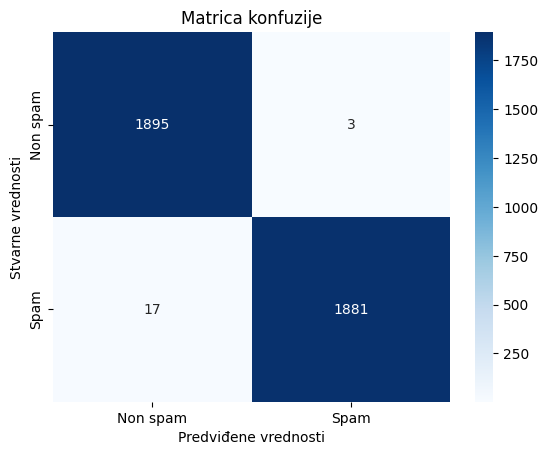

In [61]:
report(random_forest, X_resampled, y_resampled)
plot_confusion_matrix(random_forest, X_resampled, y_resampled)

#### Test podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       633
           1       0.94      0.92      0.93       420

    accuracy                           0.94      1053
   macro avg       0.94      0.94      0.94      1053
weighted avg       0.94      0.94      0.94      1053

----------------------------------------------------------------------------------------------


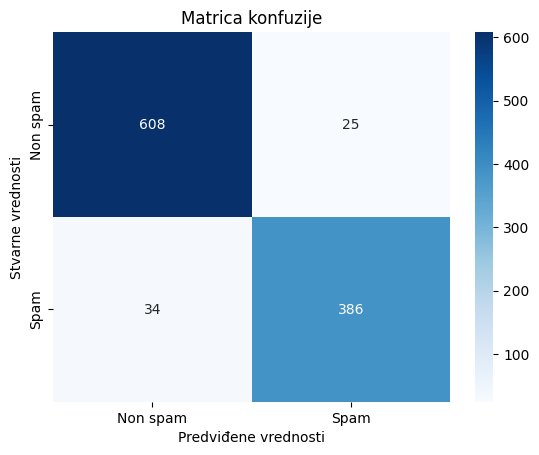

In [62]:
report(random_forest, X_test, y_test, 'test')
plot_confusion_matrix(random_forest, X_test, y_test)

> Tačnost u ovom slučaju iznosi <b>0.94</b> što nam govori da model radi sasvim zadovoljavajuće.

### Poređenje modela

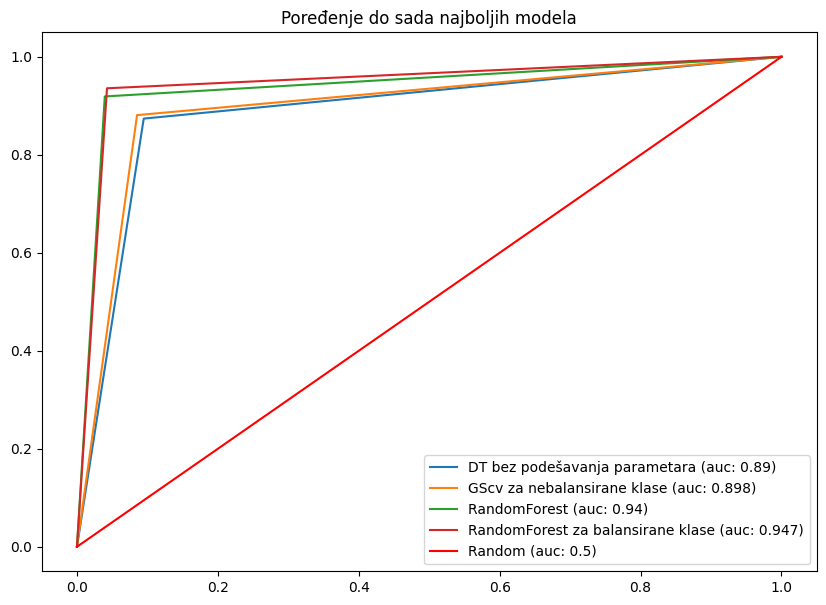

In [63]:
models = [fst_decision_tree_classifier, fst_estimator, random_forest, snd_random_forest]
model_names = ['DT bez podešavanja parametara', 'GScv za nebalansirane klase', 'RandomForest', 'RandomForest za balansirane klase']

plot_ROC_curve(models, model_names, 'Poređenje do sada najboljih modela')

> Od svih kreiranih modela, RandomForestClassifier daje najbolje moguće rezultate. 
> I u slučaju kad su klase balansirane, a i kada nisu, dobijamo tačnost od <b>0.94</b> nad test podacima. AUC vrednost je za nijansu veća kada imamo izbalansirane klase.

### Pretraga hiper-parametara

Pošto vidimo da RandomForestClassifier daje najbolje rezultate nad podacima kod kojih su klase balansirane, pokušavamo da izvršimo pretragu hiper-parametara kako bismo dodatno poboljšali performanse.

In [64]:
params = {
    'n_estimators': [80, 90, 100, 110, 120, 130, 140, 150],
    'max_features': ['sqrt', 'log2', 'auto'] 
}

random_forest_estimator = GridSearchCV(RandomForestClassifier(random_state= 42), param_grid= params, cv= 3)
random_forest_estimator.fit(X_resampled, y_resampled)

/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarni

/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/

/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/milica/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/milica/.local/lib/python3.10/site-packages/

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': ['sqrt', 'log2', 'auto'],
                         'n_estimators': [80, 90, 100, 110, 120, 130, 140,
                                          150]})

#### Trening podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1898

    accuracy                           1.00      3796
   macro avg       1.00      1.00      1.00      3796
weighted avg       1.00      1.00      1.00      3796

----------------------------------------------------------------------------------------------


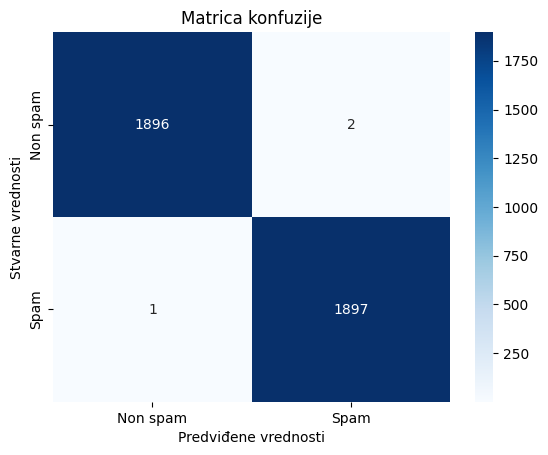

In [65]:
report(random_forest_estimator.best_estimator_, X_resampled, y_resampled)
plot_confusion_matrix(random_forest_estimator.best_estimator_, X_resampled, y_resampled)

#### Test podaci

	Klasifikacioni izveštaj za model RandomForestClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       633
           1       0.93      0.94      0.93       420

    accuracy                           0.95      1053
   macro avg       0.95      0.95      0.95      1053
weighted avg       0.95      0.95      0.95      1053

----------------------------------------------------------------------------------------------


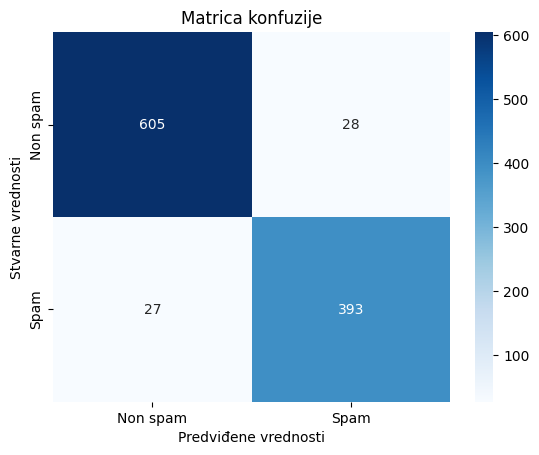

In [66]:
report(random_forest_estimator.best_estimator_, X_test, y_test)
plot_confusion_matrix(random_forest_estimator.best_estimator_, X_test, y_test)

> Nakon što su određeni najbolji hiper-parametri, tačnost ovog modela nad test podacima iznosi <b>0.95</b>.

## Balanced Random Forest Classifier

In [67]:
balanced_random_forest = BalancedRandomForestClassifier(n_estimators= 110)
balanced_random_forest.fit(X_train, y_train)

/tmp/ipykernel_12442/4174257451.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  balanced_random_forest.fit(X_train, y_train)


BalancedRandomForestClassifier(n_estimators=110)

#### Trening podaci

	Klasifikacioni izveštaj za model BalancedRandomForestClassifier nad trening podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1898
           1       0.99      1.00      1.00      1259

    accuracy                           1.00      3157
   macro avg       1.00      1.00      1.00      3157
weighted avg       1.00      1.00      1.00      3157

----------------------------------------------------------------------------------------------


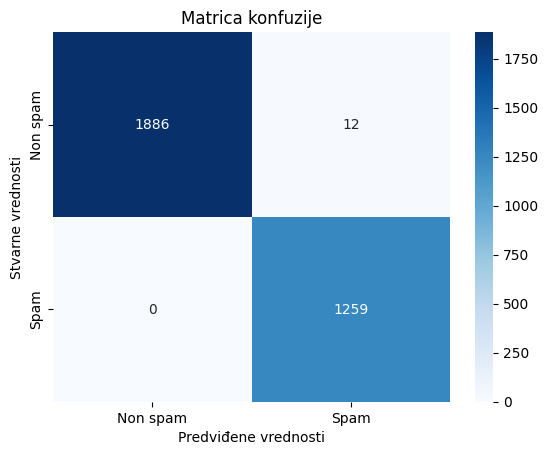

In [68]:
report(balanced_random_forest, X_train, y_train)
plot_confusion_matrix(balanced_random_forest, X_train, y_train)

#### Test podaci

	Klasifikacioni izveštaj za model BalancedRandomForestClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       633
           1       0.92      0.93      0.93       420

    accuracy                           0.94      1053
   macro avg       0.94      0.94      0.94      1053
weighted avg       0.94      0.94      0.94      1053

----------------------------------------------------------------------------------------------


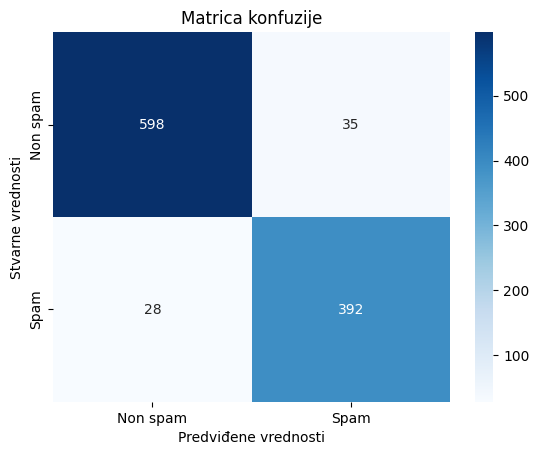

In [69]:
report(balanced_random_forest, X_test, y_test, 'test')
plot_confusion_matrix(balanced_random_forest, X_test, y_test)

### Poređenje modela dobijenih ansambl metodama

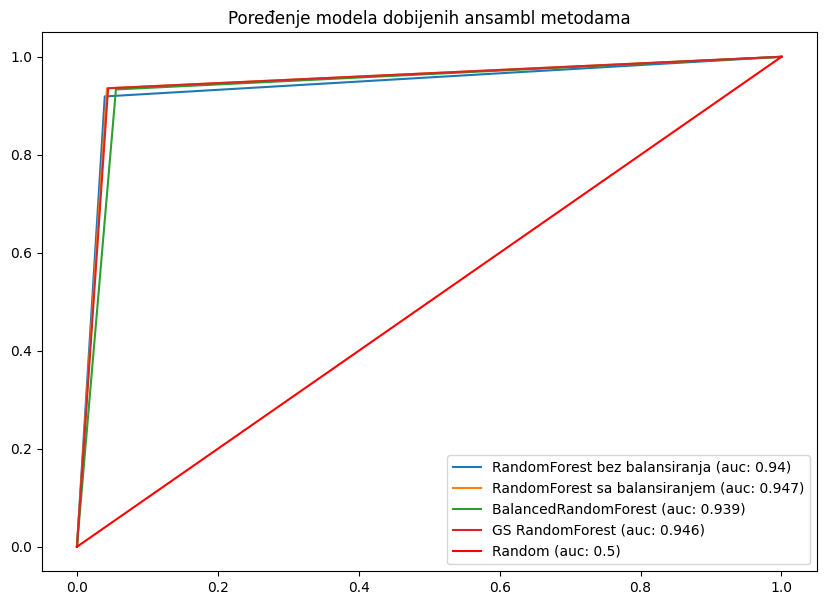

In [70]:
models = [random_forest, snd_random_forest, balanced_random_forest, random_forest_estimator]
model_names = ['RandomForest bez balansiranja', 'RandomForest sa balansiranjem', \
               'BalancedRandomForest', 'GS RandomForest']

plot_ROC_curve(models, model_names, 'Poređenje modela dobijenih ansambl metodama')

## <u>Zaključak</u>

Iz priloženog možemo videti da su se najbolje pokazali algoritmi koji rade uz korišćenje ansambl metoda, odnosno oni koji su kreirani pomoću (Balanced)RandomForestClassifier-a. Sledi lista kreiranih modela, njihove tačnosti nad podacima iz test skupa, kao i AUC vrednosti:

|                 Model                     |   Tačnost   |     AUC       |
| :----:                                    |    :----:   |    :----:     |
| RandomForest bez balansiranih klasa       | <b>0.94</b> | <b>0.94</b>   |
| RandomForest sa balansiranim klasama      | <b>0.95</b> | <b>0.947</b>  |
| BalancedRandomForest                      | <b>0.95</b> | <b>0.946</b>  |


Modeli kreirani na samom početku, čak ni uz iscrpnu pretragu hiper-parametara nisu dali preterano dobre rezultate. Međutim, nije isključeno da bi oni davali bolje performanse da smo prostor pretrage dodatno proširili nekim parametrima ili da za neke parametre uopšte nismo ni vršili pretragu već ostavili njihove podrazumevane vrednosti.

<i>Napomene</i>: 
- neke od funkcija za vizuelizaciju podataka su preuzete u celosti iz materijala sa časova, dok su neke minimalno modifikovane.
- slike drveta odlučivanja u boljoj rezoluciji mogu se pronaći u direktorijumu images, a tamo su smešteni i odgovarajući .dot fajlovi (format u kome se stablo inicijalno čuva i na osnovu kog se kreira slika).